## Setup

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import nibabel as nib

from scipy import ndimage

/Users/kw/neuefische/alzheimer-classification/.venv/lib/python3.9/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


## Get data and Preprocessing

In [2]:
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min0 = min(np.unique(volume))
    max0 = max(np.unique(volume))
    #[volume < min0] = min0
    #volume[volume > max0] = max0
    volume = (volume - min0) / (max0 - min0)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[2]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor,1), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

In [8]:
# open meta sheet for train
data_info = pd.read_csv('../data/OASIS/meta_train.csv')
normal_scan_paths = data_info.loc[data_info.CDR == 0, 'file'].to_list()
mild_scan_paths = data_info.loc[data_info.CDR == 0.5, 'file'].to_list()
severe_scan_paths = data_info.loc[data_info.CDR > 0.5, 'file'].to_list()

print("helthy MRI scans: " + str(len(normal_scan_paths)))
print("mild AD MRI scans: " + str(len(mild_scan_paths)))
print("severe AD MRI scans: " + str(len(severe_scan_paths)))

helthy MRI scans: 177
mild AD MRI scans: 40
severe AD MRI scans: 14


In [9]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])
mild_scans = np.array([process_scan(path) for path in mild_scan_paths])
severe_scans = np.array([process_scan(path) for path in severe_scan_paths])

# For the CT scans having presence of viral pneumonia
# assign 1, for the normal ones assign 0.
normal_labels = np.array([0 for _ in range(len(normal_scans))])
mild_labels = np.array([1 for _ in range(len(mild_scans))])
severe_labels = np.array([2 for _ in range(len(severe_scans))])



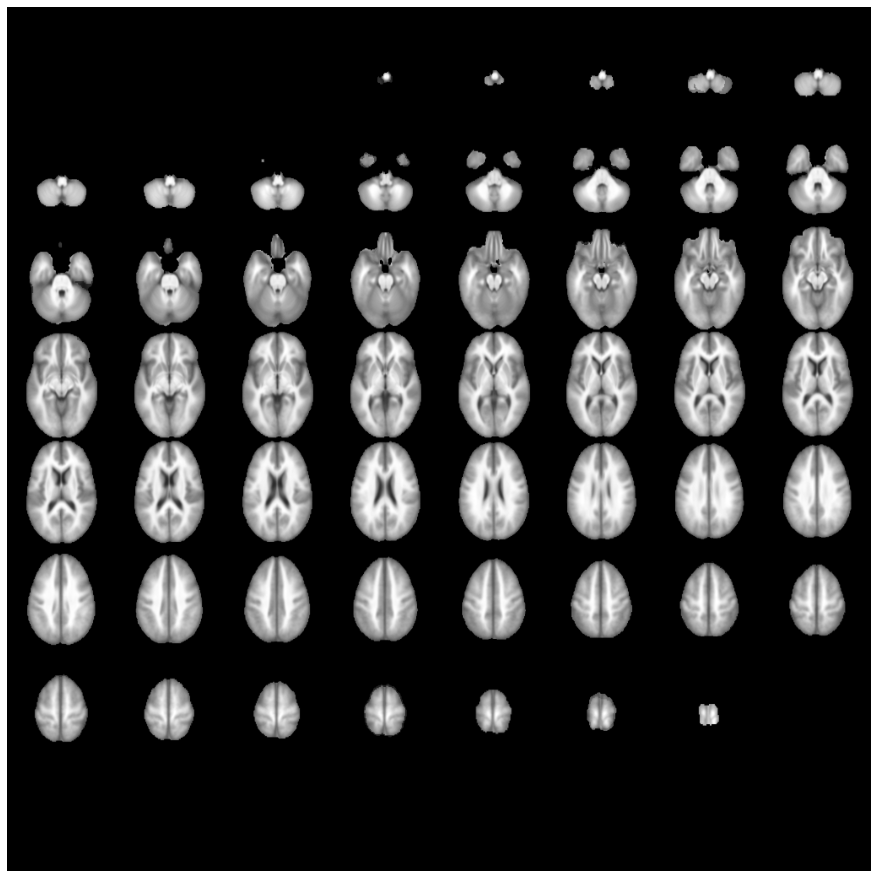

In [22]:
import matplotlib.pyplot as plt

def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()




In [27]:
normal_scans_avg = np.mean(list(normal_scans), axis=0)
mild_scans_avg = np.mean(list(mild_scans), axis=0)
severe_scans_avg = np.mean(list(severe_scans), axis=0)

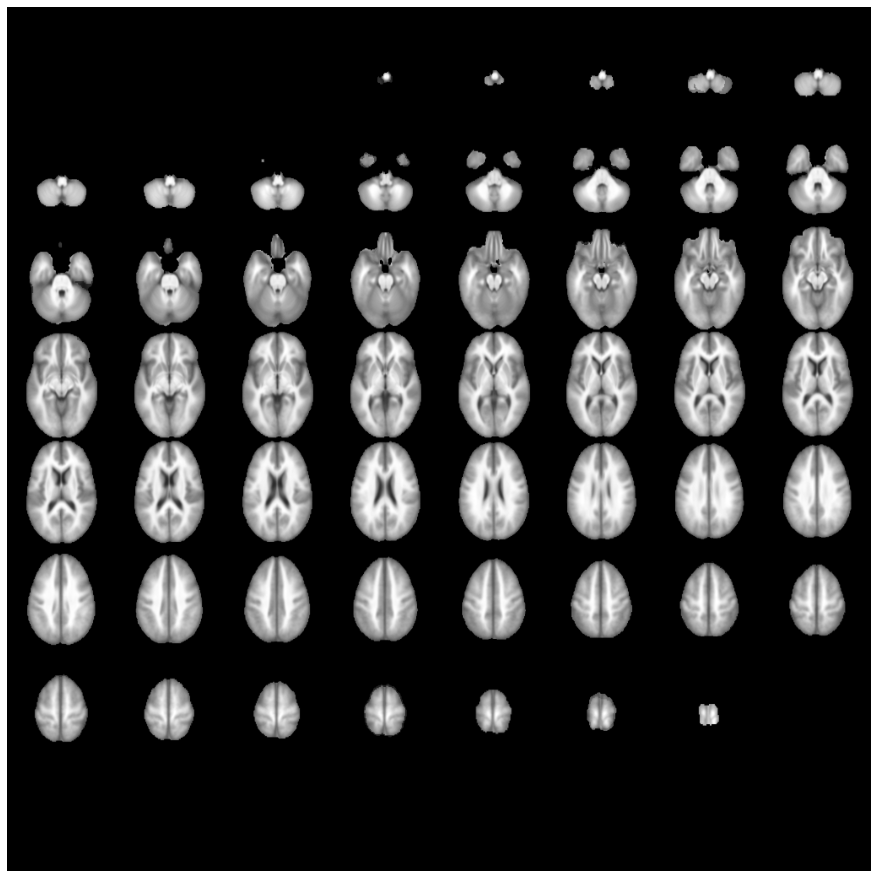

In [28]:
# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
#plot_slices(4, 10, 128, 128, image[:, :, :40])
plot_slices(8, 8, 128, 128, normal_scans_avg)

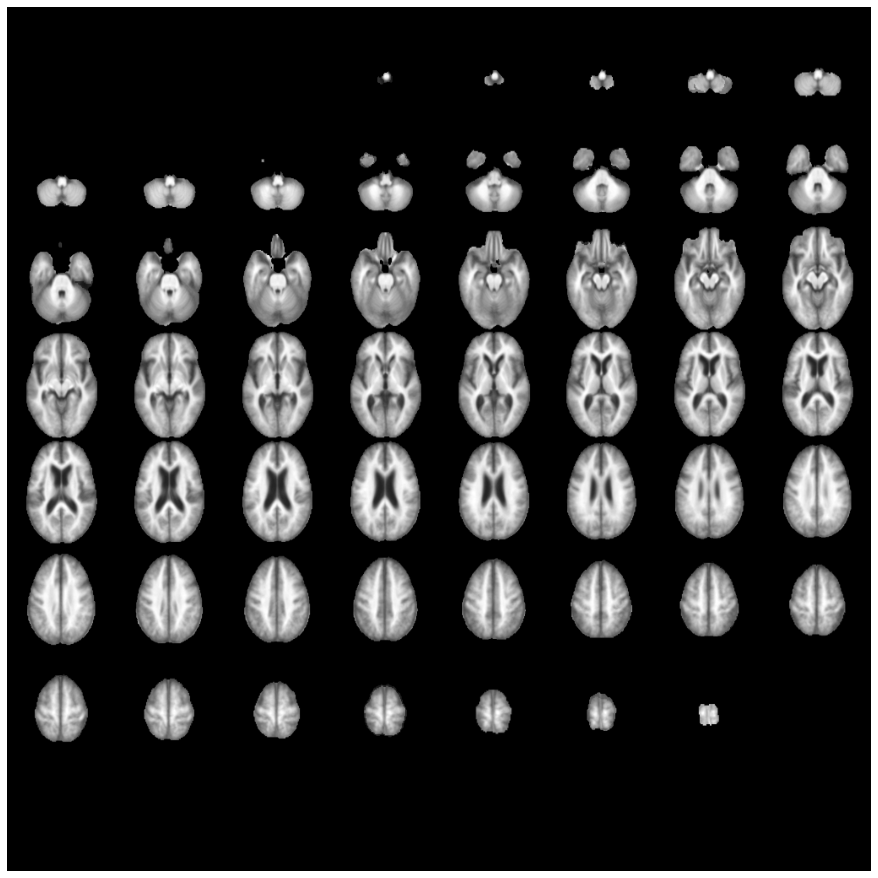

In [25]:
plot_slices(8, 8, 128, 128, mild_scans_avg)

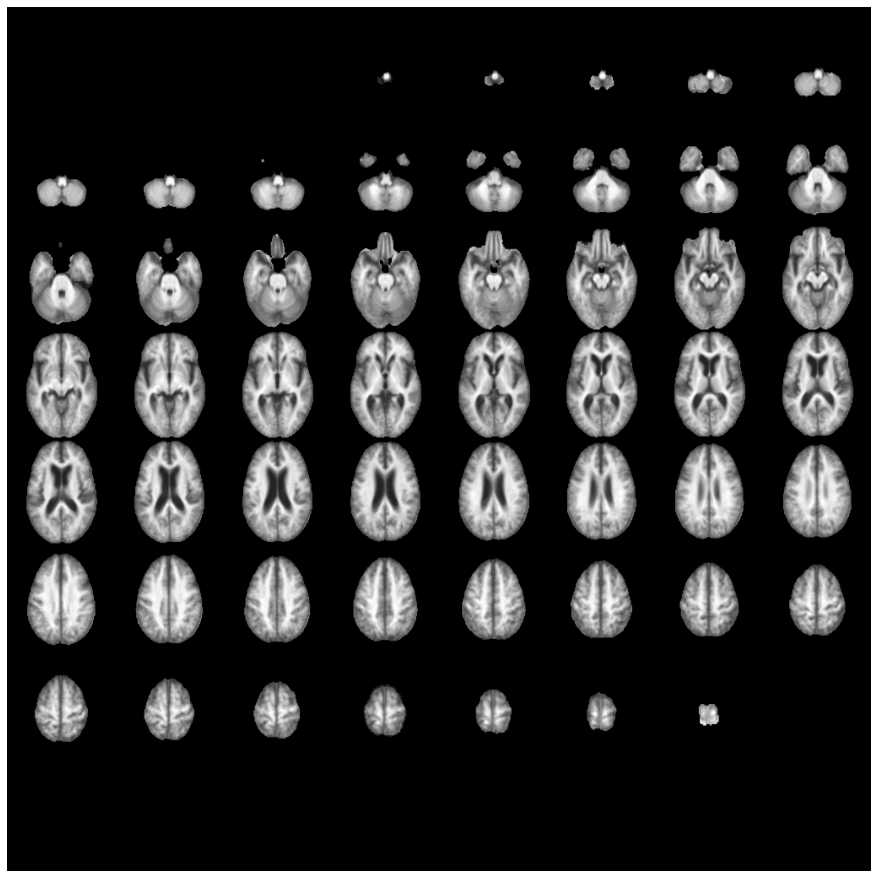

In [29]:
plot_slices(8, 8, 128, 128, severe_scans_avg)

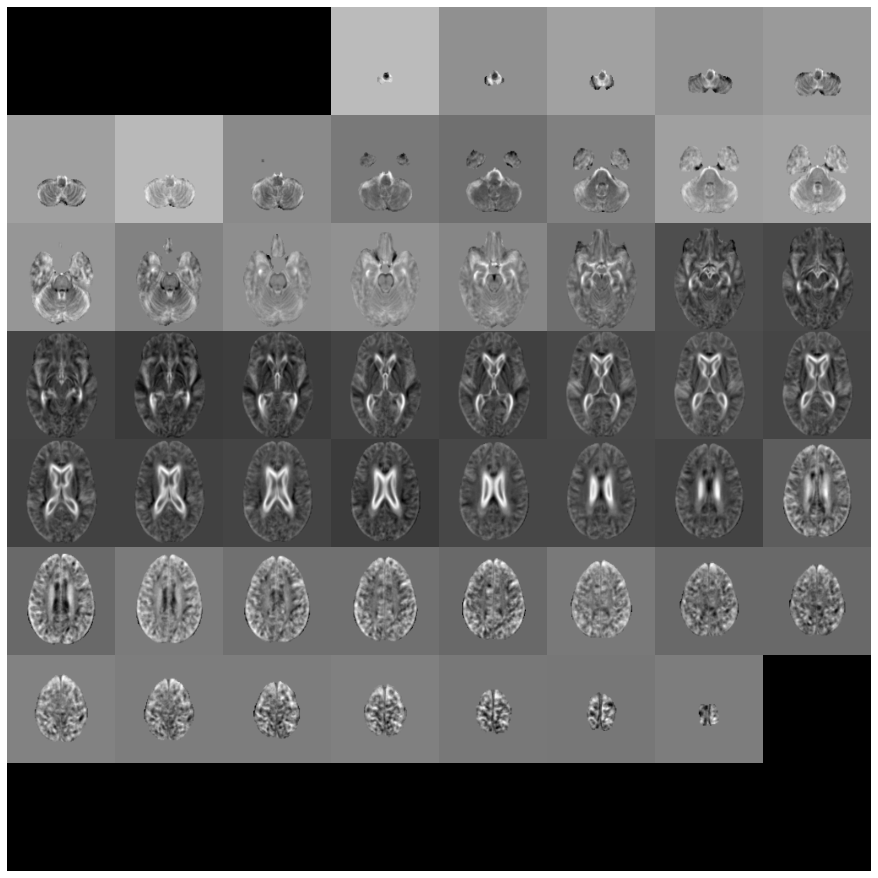

In [31]:
mild_diff =  normal_scans_avg - mild_scans_avg
plot_slices(8, 8, 128, 128, mild_diff)

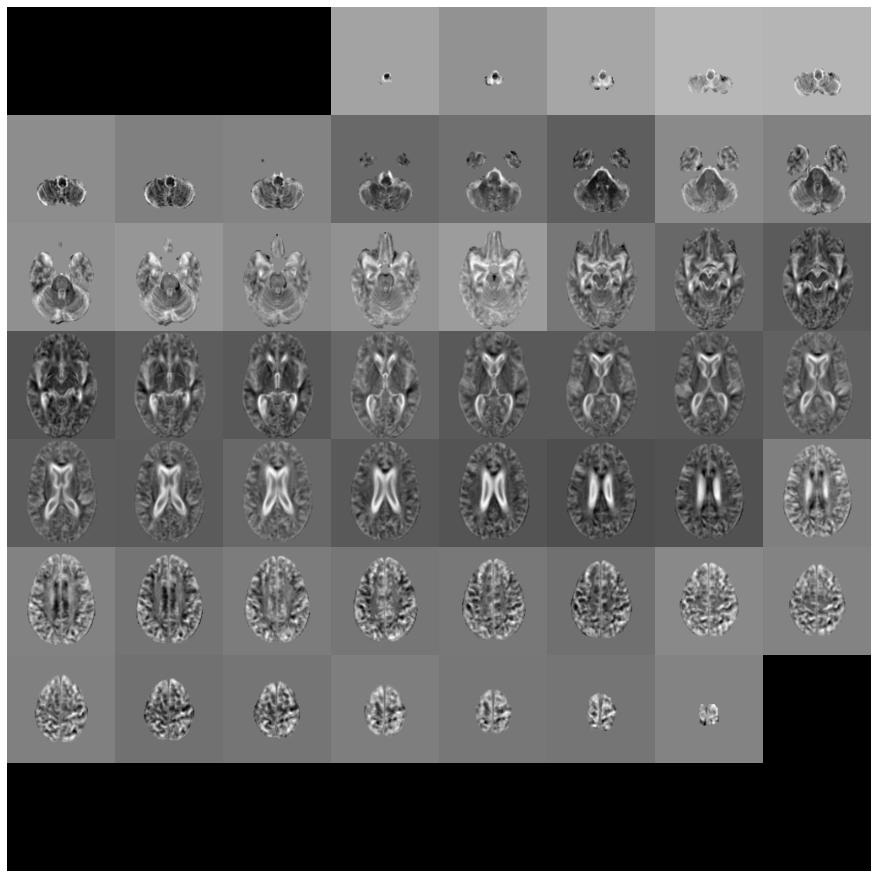

In [32]:
severe_diff =  normal_scans_avg - severe_scans_avg
plot_slices(8, 8, 128, 128, severe_diff)